In [11]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.backends.backend_pdf import PdfPages


from icedef import constants, iceberg, metocean, drift, tools, simulator
from icedef import statoil_arcticnet_data as statoil_data

# Setup Initial Conditions and Reference Track

In [2]:
df = statoil_data.get_df(statoil_data.dir_path, statoil_data.csv_filenames[2])

start_index = 1100
end_index = 1120

ref_berg = statoil_data.create_ref_berg_from_df(df, start_index, end_index)
ref_times = ref_berg.history['time']
ref_lats = xr.DataArray(ref_berg.history['latitude'], coords=[ref_times], dims=['time'])
ref_lons = xr.DataArray(ref_berg.history['longitude'], coords=[ref_times], dims=['time'])

start_time = np.datetime64(df.DataDate_UTC[start_index])
end_time = np.datetime64(df.DataDate_UTC[end_index])

start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
#start_velocity = statoil_data.get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)
start_velocity = (0.06412841, -0.10386169)  # hard-coding initial berg velocity to equal initial current velocity

time_step = np.timedelta64(360, 's')
time_info = (time_step, end_time)

# Run Test Simulation

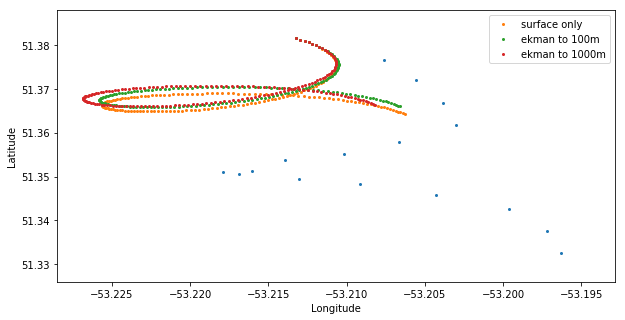

In [3]:
xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                           start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True)

fig = plt.figure(figsize=(10, 5))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(ref_lons, ref_lats, s=4)

xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                           start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=False)

plt.scatter(xds['longitude'], xds['latitude'], s=4, label='surface only')


xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                           start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True)

plt.scatter(xds['longitude'], xds['latitude'], s=4, label='ekman to 100m')


xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                                start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True,
                                depth_vec=np.arange(0, -1100, -100))

plt.scatter(xds['longitude'], xds['latitude'], s=4, label='ekman to 1000m')


plt.legend()
plt.show()

# Optimize Ca and Cw

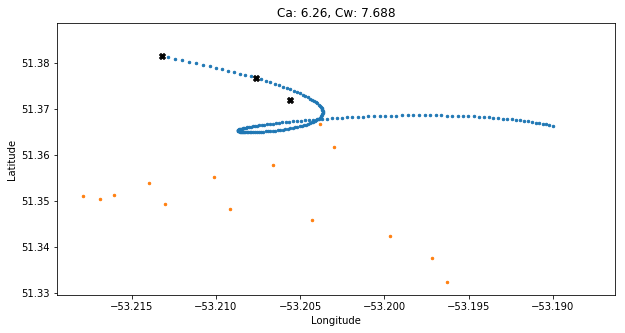

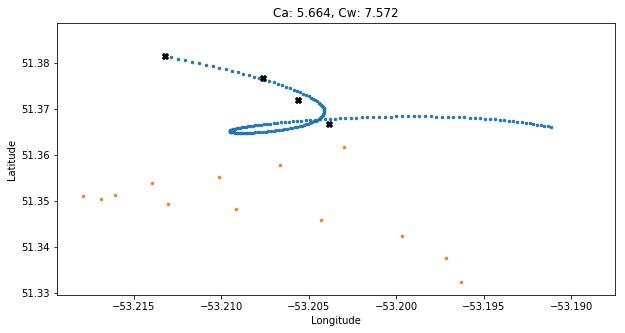

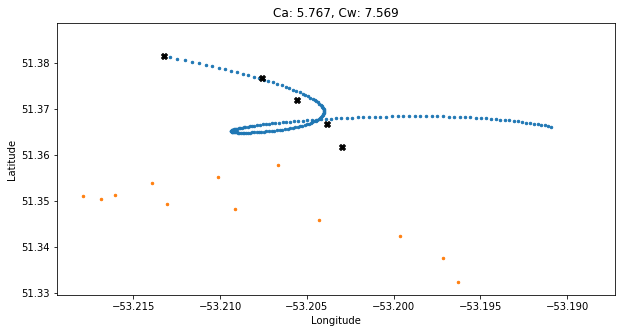

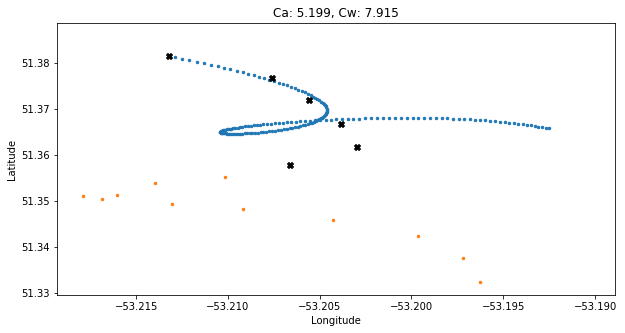

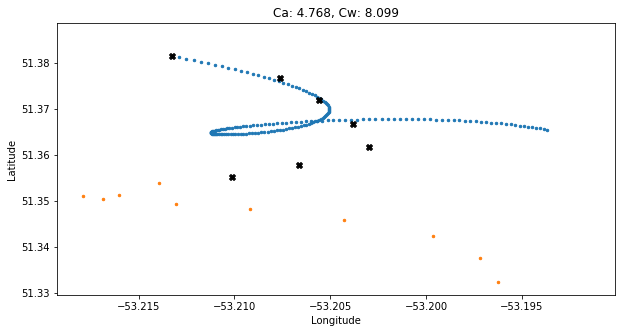

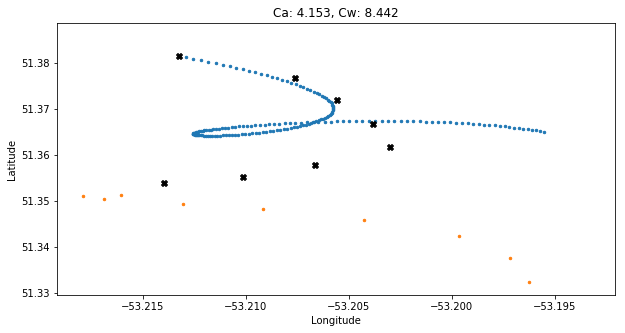

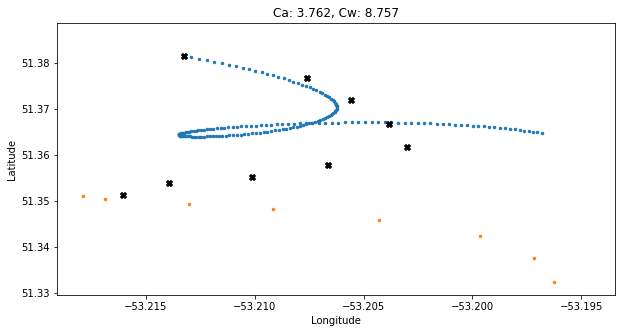

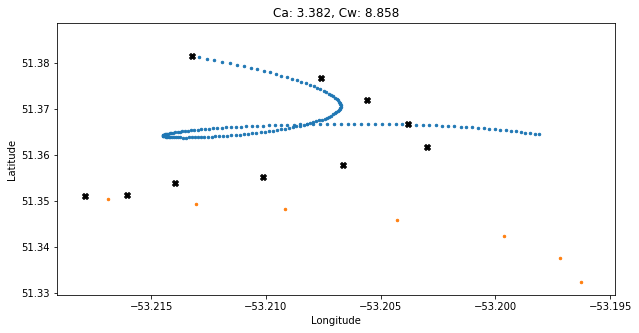

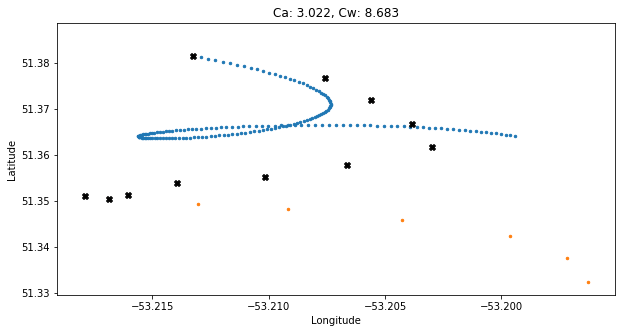

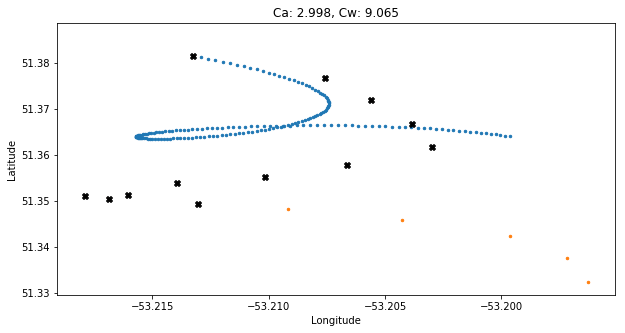

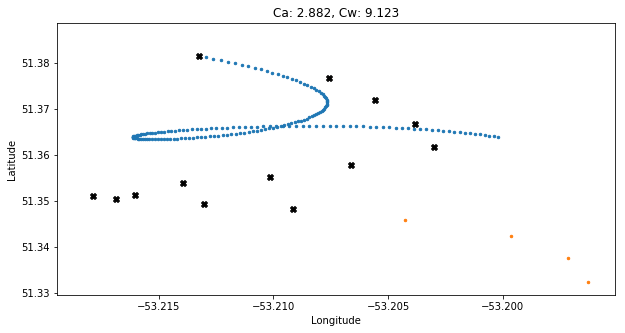

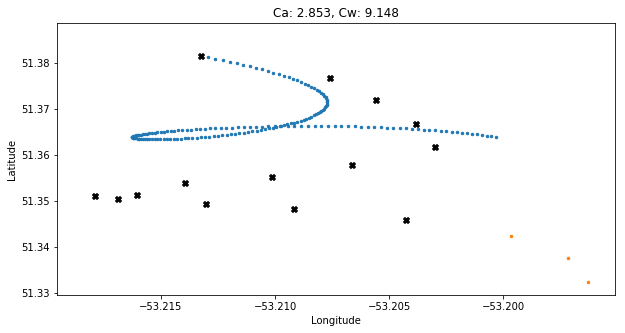

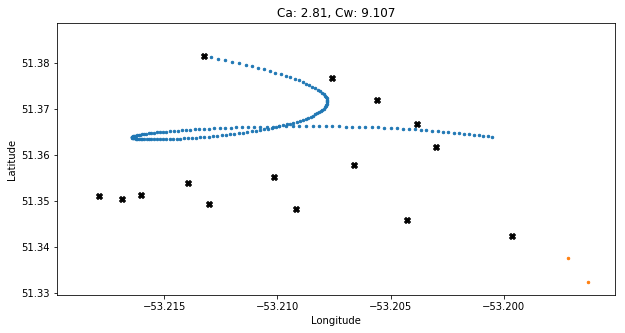

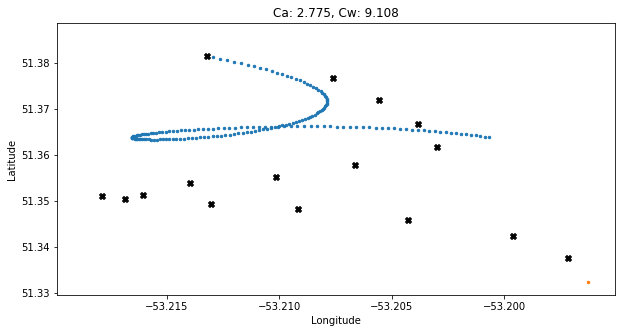

In [14]:
optimization_result_list = []
with PdfPages('plots/optim_steps2.pdf') as pdf:
    for i in range(2, len(ref_lons) - 1):
        bounds = ((0, 10), (0, 10))
        optimization_result = simulator.run_optimization((ref_lats[:i+1], ref_lons[:i+1]), 
                                                         (start_latitude, start_longitude), 
                                                         (start_time, ref_times[i+1] + np.timedelta64(6, 'h')), 
                                                         bounds=bounds)
        optimization_result_list.append(optimization_result)
        Ca, Cw = optimization_result.x

        xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                                  start_velocity=start_velocity, Ca=Ca, Cw=Cw)

        fig = plt.figure(figsize=(10, 5))
        plt.title('Ca: {}, Cw: {}'.format(round(Ca, 3), round(Cw, 3)))
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.scatter(xds['longitude'], xds['latitude'], s=6)
        plt.scatter(ref_lons, ref_lats, s=6)
        plt.scatter(ref_lons[:i+1], ref_lats[:i+1], marker='X', c='black')
        plt.show()
        pdf.savefig(fig)

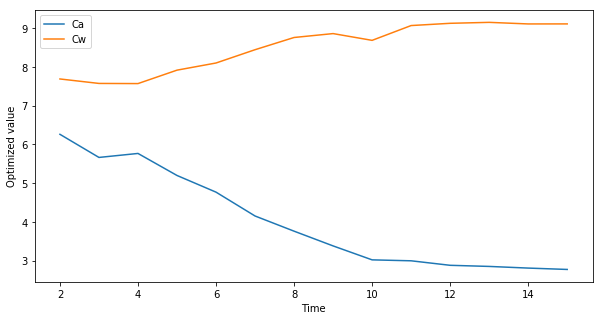

In [19]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, len(ref_lons) - 1), [res.x[0] for res in optimization_result_list], label='Ca')
plt.plot(range(2, len(ref_lons) - 1), [res.x[1] for res in optimization_result_list], label='Cw')
plt.ylabel('Optimized value')
plt.xlabel('Time')
plt.legend()
plt.show()

In [70]:
def scatter_track_and_quiver_vectors(lats, lons, vectors, **kwargs):
    
    plot_width = kwargs.pop('plot_width', 10)
    plot_height = kwargs.pop('plot_height', 5)
    
    fig = plt.figure(figsize=(plot_width, plot_height))
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    gap = kwargs.pop('gap', 10)
    track_marker_size = kwargs.pop('track_marker_size', 5)
    ref_marker_size = kwargs.pop('ref_marker_size', 5)
    arrow_scale = kwargs.pop('arrow_scale', None)
    arrow_shaftwidth = kwargs.pop('arrow_shaftwidth', 0.0005 * plot_width)
    arrow_headlength = kwargs.pop('arrow_headlength', 5)
    arrow_headwidth = kwargs.pop('arrow_headwidth', 3)
    arrow_colors = kwargs.pop('arrow_colors', ['black'] * 10)
    arrow_labels = kwargs.pop('arrow_labels', [''] * 10)
    ref_track = kwargs.pop('ref_track', None)
    
    if ref_track is not None:
        
        ref_lats, ref_lons = ref_track
        plt.scatter(ref_lons, ref_lats, s=ref_marker_size, label='reference')
    
    plt.scatter(lons, lats, s=track_marker_size, label='')
    
    i = 0
    
    for vector_u, vector_v in vectors:
        
        plt.quiver(lons[::gap], lats[::gap, ], vector_u[::gap], vector_v[::gap],
                   scale=arrow_scale, width=arrow_shaftwidth, headlength=arrow_headlength,
                   headwidth=arrow_headwidth, color=arrow_colors[i], label=arrow_labels[i])
        i += 1
        
    if arrow_labels[0] is not '':
        
        plt.legend()
    
    plt.show()

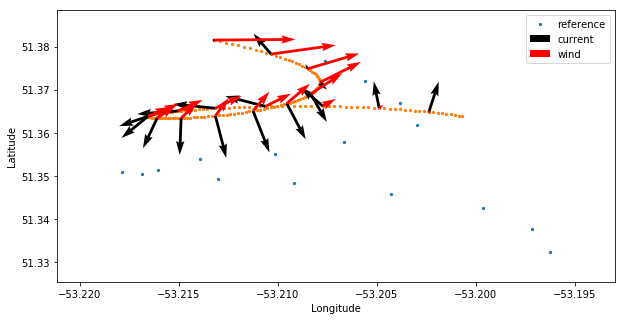

In [71]:
scatter_track_and_quiver_vectors(xds['latitude'], xds['longitude'], 
                                 [
                                     [xds['current_eastward_force'], xds['current_northward_force']],
                                     [xds['wind_eastward_force'], xds['wind_northward_force']],
                                 ], 
                                 arrow_colors=['black', 'red'], 
                                 arrow_labels=['current', 'wind'],
                                 ref_track=(ref_lats, ref_lons))